
WELL-CONDITIONED QUADRATIC (condition number = 10)
Well-Conditioned Quadratic | SGD+Momentum                   converged in  1258 iterations, final loss: 4.92e-13
Well-Conditioned Quadratic | Adam                           converged in   936 iterations, final loss: 2.25e-13
Well-Conditioned Quadratic | RMSProp                        converged in 10000 iterations, final loss: 1.22e-03
Well-Conditioned Quadratic | Reactive Adam                  converged in   494 iterations, final loss: 1.45e-14


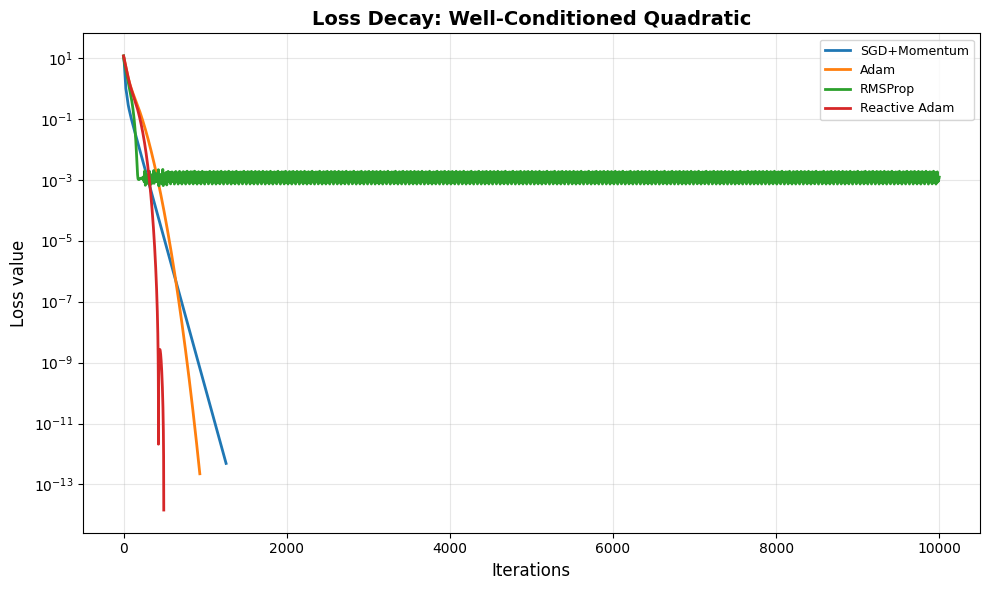


ILL-CONDITIONED QUADRATIC (condition number = 100)
Ill-Conditioned Quadratic | SGD+Momentum                   converged in 10000 iterations, final loss: 1.30e-09
Ill-Conditioned Quadratic | Adam                           converged in 10000 iterations, final loss: 8.29e-05
Ill-Conditioned Quadratic | RMSProp                        converged in 10000 iterations, final loss: 8.46e-05
Ill-Conditioned Quadratic | Reactive Adam                  converged in 10000 iterations, final loss: 5.76e-08


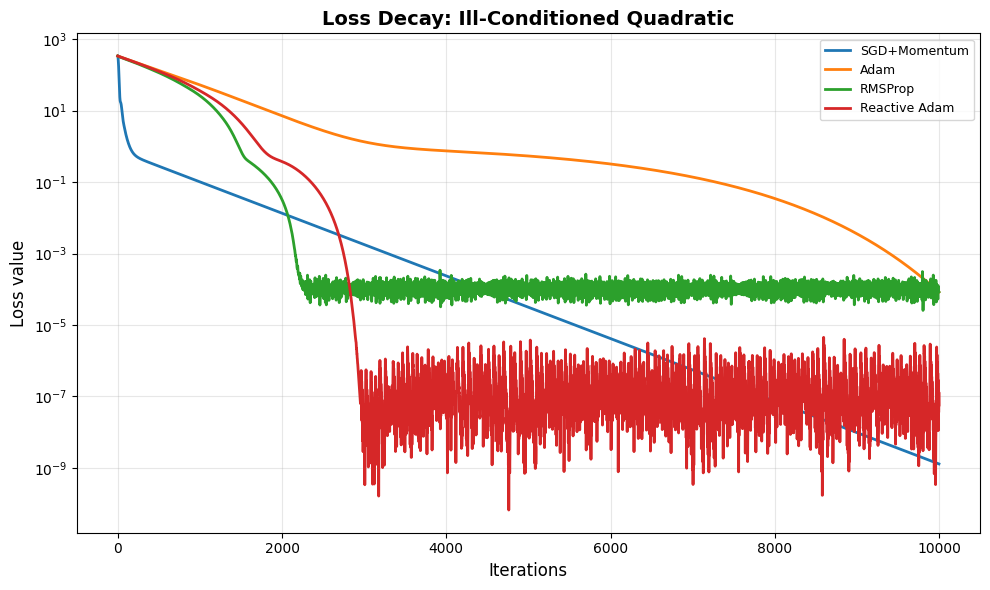


ROSENBROCK FUNCTION (highly non-convex)
Rosenbrock Function | SGD+Momentum                   converged in 10000 iterations, final loss: 5.52e-05
Rosenbrock Function | Adam                           converged in 10000 iterations, final loss: 3.69e-04
Rosenbrock Function | RMSProp                        converged in 10000 iterations, final loss: 2.25e-04
Rosenbrock Function | Reactive Adam                  converged in  3660 iterations, final loss: 1.50e-09


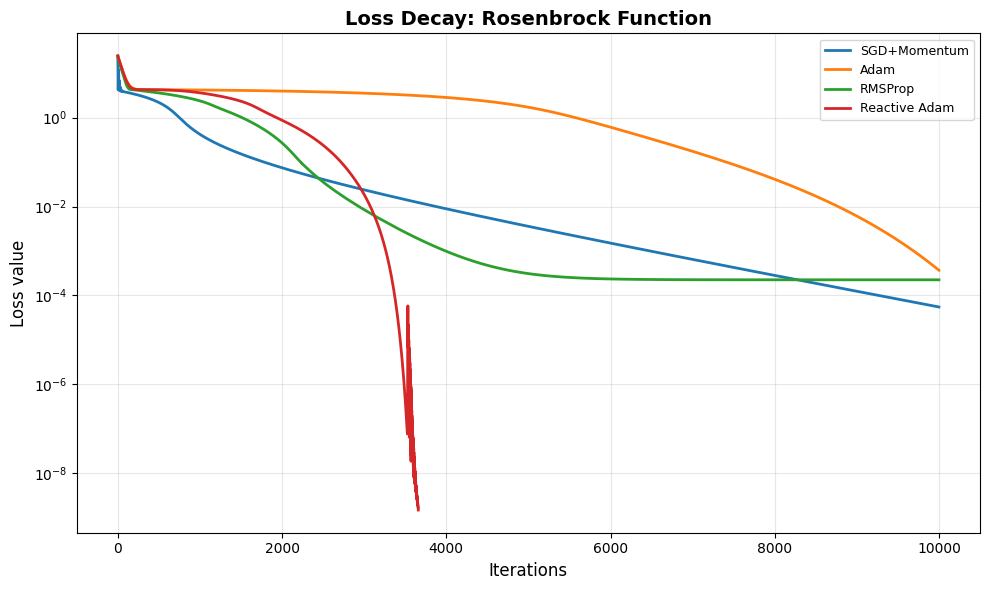


EXPERIMENTS COMPLETE


In [3]:
import numpy as np
import matplotlib.pyplot as plt

# CONFIGURATION: Set to True to test multiple hyperparameter settings
TEST_MULTIPLE_CONFIGS = False

# -------------------------------
# Helper: Quadratic function generator
# -------------------------------
def generate_quadratic(dim=10, cond_number=10):
    """Generate symmetric positive definite Q with given condition number."""
    V = np.linalg.qr(np.random.randn(dim, dim))[0]  # orthogonal matrix
    eigvals = np.linspace(1, cond_number, dim)      # spread of eigenvalues
    Q = V @ np.diag(eigvals) @ V.T
    return Q

# Quadratic function and gradient
def quadratic_f(x, Q):
    return 0.5 * x.T @ Q @ x

def quadratic_grad(x, Q):
    return Q @ x

# Rosenbrock function and gradient
def rosenbrock_f(x):
    return (1 - x[0])**2 + 100 * (x[1] - x[0]**2)**2

def rosenbrock_grad(x):
    dx = -2*(1 - x[0]) - 400*x[0]*(x[1] - x[0]**2)
    dy = 200*(x[1] - x[0]**2)
    return np.array([dx, dy])

# -------------------------------
# Optimizers (with loss tracking)
# -------------------------------
def sgd_momentum(f, grad_f, x0, lr=0.01, beta=0.9, tol=1e-6, max_iter=10000):
    x = x0.copy()
    v = np.zeros_like(x)
    losses = []
    for i in range(max_iter):
        loss = f(x)
        losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        v = beta * v + (1 - beta) * g
        x -= lr * v
    return x, i + 1, losses

def adam(f, grad_f, x0, lr=0.001, beta1=0.9, beta2=0.999, eps=1e-8, tol=1e-6, max_iter=10000):
    x = x0.copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    losses = []
    for t in range(1, max_iter + 1):
        loss = f(x)
        losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g ** 2)
        m_hat = m / (1 - beta1 ** t)
        v_hat = v / (1 - beta2 ** t)
        x -= lr * m_hat / (np.sqrt(v_hat) + eps)
    return x, t, losses

def rmsprop(f, grad_f, x0, lr=0.001, beta=0.9, eps=1e-8, tol=1e-6, max_iter=10000):
    x = x0.copy()
    s = np.zeros_like(x)
    losses = []
    for i in range(max_iter):
        loss = f(x)
        losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        s = beta * s + (1 - beta) * (g ** 2)
        x -= lr * g / (np.sqrt(s) + eps)
    return x, i + 1, losses

def reactive_adam(f, grad_f, x0, lr=0.001, beta1=0.9, beta2=0.99, c=0.15, d=0.05, eps=1e-8, tol=1e-6, max_iter=10000, warmup=10):
    """
    Reactive Adam optimizer with multiple enhancements:
    1. Momentum term (like Adam) for smoother updates
    2. Separate betas for gradient momentum vs variance
    3. Warmup period to stabilize early training
    4. Smoother adaptive gains with exponential moving average
    5. Better clamping strategy for stability
    """
    x = x0.copy()
    m = np.zeros_like(x)  # First moment (momentum)
    v = np.zeros_like(x)  # Second moment (variance)
    prev_grad = np.zeros_like(x)
    prev_v = np.zeros_like(x)
    grad_change_ema = np.zeros_like(x)  # EMA of gradient changes
    losses = []
    
    for t in range(max_iter):
        loss = f(x)
        losses.append(loss)
        g = grad_f(x)
        if np.linalg.norm(g) < tol:
            break
        
        # Track gradient change with EMA for smoother adaptive gains
        grad_change = np.abs(g - prev_grad)
        grad_change_ema = 0.9 * grad_change_ema + 0.1 * grad_change
        
        # Adaptive gradient gain with warmup
        if t < warmup:
            # During warmup, reduce adaptation to stabilize
            wg = 1.0 + (t / warmup) * c * (grad_change_ema / (np.abs(g) + eps))
        else:
            wg = 1.0 + c * (grad_change_ema / (np.abs(g) + eps))
        
        # Clamp gradient gain to reasonable range
        wg = np.clip(wg, 0.5, 2.0)
        
        # Update first moment (momentum)
        m = beta1 * m + (1 - beta1) * g
        
        # Update second moment with adaptive gradient
        wg_grad = wg * g
        v = beta2 * v + (1 - beta2) * (wg_grad ** 2)
        
        # Bias correction (like Adam)
        m_hat = m / (1 - beta1 ** (t + 1))
        v_hat = v / (1 - beta2 ** (t + 1))
        
        # Adaptive variance gain (more conservative)
        if t > 0:
            v_change_ratio = np.abs(v_hat - prev_v) / (v_hat + eps)
            wv = 1.0 - d * v_change_ratio
            wv = np.clip(wv, 0.5, 1.5)
        else:
            wv = 1.0
        
        # Parameter update with both momentum and adaptive gains
        denom = np.sqrt(wv * v_hat) + eps
        x -= lr * m_hat / denom
        
        # Save state
        prev_grad = g.copy()
        prev_v = v_hat.copy()
    
    return x, t + 1, losses

# -------------------------------
# Experiment Runner + Plotter
# -------------------------------
def run_and_plot(f, grad_f, x0, optimizers, tol, f_name, logy=True):
    plt.figure(figsize=(10, 6))
    for name, opt in optimizers.items():
        # many of your lambdas accept the default-initialized x variable name as a keyword;
        # to be robust we call opt with the three positional args (f, grad_f, x0)
        x_opt, n_iter, losses = opt(f, grad_f, x0)
        final_loss = losses[-1] if len(losses) > 0 else float('nan')
        print(f"{f_name} | {name:30s} converged in {n_iter:5d} iterations, final loss: {final_loss:.2e}")
        plt.plot(losses, label=name, linewidth=2)
    if logy:
        plt.yscale('log')
    plt.xlabel("Iterations", fontsize=12)
    plt.ylabel("Loss value", fontsize=12)
    plt.title(f"Loss Decay: {f_name}", fontsize=14, fontweight='bold')
    plt.legend(fontsize=9)
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# -------------------------------
# 1️⃣ Well-conditioned Quadratic
# -------------------------------
print("\n" + "="*70)
print("WELL-CONDITIONED QUADRATIC (condition number = 10)")
print("="*70)
dim = 10
Q_well = generate_quadratic(dim, cond_number=10)
x0_well = np.random.randn(dim)

if TEST_MULTIPLE_CONFIGS:
    optimizers = {
        "SGD+Momentum": lambda f, g, x_init=x0_well: sgd_momentum(f, g, x_init, lr=0.01),
        "Adam": lambda f, g, x_init=x0_well: adam(f, g, x_init, lr=0.01),
        "RMSProp": lambda f, g, x_init=x0_well: rmsprop(f, g, x_init, lr=0.01),
        "Reactive Adam": lambda f, g, x_init=x0_well: reactive_adam(f, g, x_init, lr=0.01),
    }
else:
    optimizers = {
        "SGD+Momentum": lambda f, g, x_init=x0_well: sgd_momentum(f, g, x_init, lr=0.01),
        "Adam": lambda f, g, x_init=x0_well: adam(f, g, x_init, lr=0.01),
        "RMSProp": lambda f, g, x_init=x0_well: rmsprop(f, g, x_init, lr=0.01),
        "Reactive Adam": lambda f, g, x_init=x0_well: reactive_adam(f, g, x_init, lr=0.01),
    }

run_and_plot(lambda x: quadratic_f(x, Q_well),
             lambda x: quadratic_grad(x, Q_well),
             x0_well, optimizers, tol=1e-6, f_name="Well-Conditioned Quadratic")

# -------------------------------
# 2️⃣ Ill-conditioned Quadratic
# -------------------------------
print("\n" + "="*70)
print("ILL-CONDITIONED QUADRATIC (condition number = 100)")
print("="*70)
Q_ill = generate_quadratic(dim, cond_number=100)
x0_ill = np.random.randn(dim)

if TEST_MULTIPLE_CONFIGS:
    optimizers_ill = {
        "SGD+Momentum": lambda f, g, x_init=x0_ill: sgd_momentum(f, g, x_init, lr=0.001),
        "Adam": lambda f, g, x_init=x0_ill: adam(f, g, x_init, lr=0.001),
        "RMSProp": lambda f, g, x_init=x0_ill: rmsprop(f, g, x_init, lr=0.001),
        "Reactive Adam": lambda f, g, x_init=x0_ill: reactive_adam(f, g, x_init, lr=0.001),
    }
else:
    optimizers_ill = {
        "SGD+Momentum": lambda f, g, x_init=x0_ill: sgd_momentum(f, g, x_init, lr=0.001),
        "Adam": lambda f, g, x_init=x0_ill: adam(f, g, x_init, lr=0.001),
        "RMSProp": lambda f, g, x_init=x0_ill: rmsprop(f, g, x_init, lr=0.001),
        "Reactive Adam": lambda f, g, x_init=x0_ill: reactive_adam(f, g, x_init, lr=0.001),
    }

run_and_plot(lambda x: quadratic_f(x, Q_ill),
             lambda x: quadratic_grad(x, Q_ill),
             x0_ill, optimizers_ill, tol=1e-6, f_name="Ill-Conditioned Quadratic")

# -------------------------------
# 3️⃣ Rosenbrock Function
# -------------------------------
print("\n" + "="*70)
print("ROSENBROCK FUNCTION (highly non-convex)")
print("="*70)
x0_rosen = np.array([-1.2, 1.0])

if TEST_MULTIPLE_CONFIGS:
    optimizers_rosen = {
        "SGD+Momentum": lambda f, g, x_init=x0_rosen: sgd_momentum(f, g, x_init, lr=0.001, tol=1e-4),
        "Adam": lambda f, g, x_init=x0_rosen: adam(f, g, x_init, lr=0.001, tol=1e-4),
        "RMSProp": lambda f, g, x_init=x0_rosen: rmsprop(f, g, x_init, lr=0.001, tol=1e-4),
        "Reactive Adam": lambda f, g, x_init=x0_rosen: reactive_adam(f, g, x_init, lr=0.001, tol=1e-4),
    }
else:
    optimizers_rosen = {
        "SGD+Momentum": lambda f, g, x_init=x0_rosen: sgd_momentum(f, g, x_init, lr=0.001, tol=1e-4),
        "Adam": lambda f, g, x_init=x0_rosen: adam(f, g, x_init, lr=0.001, tol=1e-4),
        "RMSProp": lambda f, g, x_init=x0_rosen: rmsprop(f, g, x_init, lr=0.001, tol=1e-4),
        "Reactive Adam": lambda f, g, x_init=x0_rosen: reactive_adam(f, g, x_init, lr=0.001, tol=1e-4),
    }

run_and_plot(rosenbrock_f, rosenbrock_grad, x0_rosen, optimizers_rosen, tol=1e-4, f_name="Rosenbrock Function")

print("\n" + "="*70)
print("EXPERIMENTS COMPLETE")
print("="*70)